# OpenGOSim

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from scipy.stats import norm
from scipy.stats import truncnorm, beta, uniform
import umbridge

/home/anne/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Inputs:

| Variable  | Dimension    | Description |
|----------|-------------|-------------|
| POROSITY|		12 | Distribution below and permeability  is derived directly from this |
| PERMZ   |		1  | PERMZ is normally a fraction of PERMX. 
|         |        | Varies between 1 to 0.01, being the most probable value 0.1.|
| FAULT  |		2  | One parameter per fault. 
|         |        | It should vary between 1 (open) to 0 (completely closed) |
| Heteorgeneity | 1 | Modify the value 0.02.
|         |        | The value can go from 0 to 1 (I would go beyond 0.25).|


|   |            |   |
|----------|:-------------:|------:|
| POROSITY RANGE:|		0.039 |	0.366  |	
| POROSITY MEAN: |		0.2	  |        |	
| POROSITY STD:  |		0.079 |        |


|   |            |
|----------|:-------------:|
| RHI = 0|		Homogeneous reservoir |
| 0.0 < RHI <0.25 |		Slightly heterogeneous reservoir	  |	
| 0.25 < RHI <0.5 |		Heterogeneous reservoir	  |	
| 0.5 < RHI <0.75 |		Very heterogeneous reservoir	  |	
| 0.75 < RHI <1.0 |		Extremely heterogeneous reservoir	  |	
| RHI = 1.0 |		Perfectly heterogeneous reservoir; unlikely this exists	  |	

Other options:
- In the file .in you can modify the aquifer permeability (How fast the aquifer can absorb pressure changes in the system)
- You could vary PERM (1 parameter) between 1 to 1000, being 1 and 1000 quite unlikely.

So we have 12 porosities, 2 faults, 1 aquifer and 1 PERMZ scaling. Totalling 16 parameters to explore.

### Input distributions:

Let $ \boldsymbol{\theta} \in \mathbb{R}^{16} $
1. Porosity $ \phi(\mathbf{x}) \sim \mathcal{N}_{[0.039, 0.366]}(\mu=0.2, \sigma=0.079) $
2. Permeability ratio (PERMZ) $\sim \text{Beta}_{[0.01, 1]}(\alpha=2, \beta=18) $
3. Fault $\sim \text{Uniform}(0, 1) $
4. Heterogeneity $ \sim \text{Beta}(\alpha=2, \beta=8) $

with joint prior distribution $  \pi(\boldsymbol{\theta})$.


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.flatten()

mu = 0.2
sigma = 0.079
lower, upper = 0.039, 0.366
a, b = (lower - mu) / sigma, (upper - mu) / sigma
x_poro = np.linspace(lower, upper, 1000)
pdf_poro = truncnorm.pdf(x_poro, a, b, loc=mu, scale=sigma) # truncated normal
axs[0].plot(x_poro, pdf_poro, label='PORO')

alpha_pz, beta_pz = 2, 18
x_permz = np.linspace(0.01, 1, 1000)
pdf_permz = beta.pdf((x_permz - 0.01) / (1 - 0.01), alpha_pz, beta_pz) / (1 - 0.01)
axs[1].plot(x_permz, pdf_permz, label='PERMZ')

x_fault = np.linspace(0, 1, 1000)
pdf_fault = uniform.pdf(x_fault)
axs[2].plot(x_fault, pdf_fault, label='FAULT')

alpha_h, beta_h = 2, 8
x_het = np.linspace(0, 1, 1000)
pdf_het = beta.pdf(x_het, alpha_h, beta_h)
axs[3].plot(x_het, pdf_het, label='HETEROGENEITY')

for i in range(4):
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()

### Outputs
The fields you want to analyse within the -mas.dat/CSV file are the following:
- Field fgit [m^3] : this is the accumulated CO2 injected into the model. The last value of the column is the total injected, you want to inject as much as possible.

The following fields are examples for the coarse model:
- BPressure [bar] 30_30_1
- BPressure [bar] 7_7_1
- BPressure [bar] 27_11_1

These three entries have the pressure at that precise point. You want to make sure that the pressure is not above a maximum threshold. This is 200 Bar. As the model is set up right now, the well will stop injecting if the system goes above 200 Bar so in theory this will never be triggered and the effect of reaching the maximum pressure will be that the total CO2 injected will be diminished. In any case, worth monitoring. Another option is to allow the pressure of the well to go above 200 Bar or set the threshold to be lower (say 190 Bar), up to you.


For the gas reaching the NOGO area you must check the following fields:
- BSgas 7_1_1, BSgas 7_2_1, BSgas 7_3_1,  BSgas 7_4_1, BSgas 7_5_1, BSgas 7_6_1    
- BSgas 7_7_1, BSgas 1_7_1, BSgas 2_7_1,  BSgas 3_7_1, BSgas 4_7_1, BSgas 5_7_1    
- BSgas 6_7_1, BSgas 7_7_1

These provide the saturation of gas at the top cells of the NOGO area

### More on permeability

A correlation between porosity and permeability is used to generate the permeability field using the following formula:

$perm = a b^{poro c -d}$

Potential values for constants:
1. $K = 10^{(15.6 poro - 0.9)}$
2. $K = 0.003 e^{(49 poro)}$

Note that the permeability obtained with these parameters is in mD which is not S.I. units (1 mD = 9.869233e-16 m^2). The permeability is a tensor, not a scalar. Normally, only the three diagonal components are considered and the Kx = Ky and Kz is considered to be a fraction of the others using the kv/kh ratio (vertical/horizontal permeability ratio). Thus, 

$K_z = c K_x$, where $0.01\leq c \leq 0.1$.

### Model

We want to simulate the process of CO2 injection through a porous
medium. Darcy’s Law governs the flow equation.


PFLOTRAN solves the steady-state Darcy flow equation:

$$\nabla \cdot \left( \mathbf{K}(\mathbf{x}, \boldsymbol{\theta}) \nabla p(\mathbf{x}) \right) = q(\mathbf{x})$$

where:
- $\mathbf{x} \in \Omega $: spatial domain
-  $p(\mathbf{x})$: pressure
- $\mathbf{K}(\mathbf{x}, \boldsymbol{\theta})$: uncertain permeability tensor
- $q(\mathbf{x})$: source/sink term



y=M(θ)


M is the PFLOTRAN simulation and y are quantities of interest

- Darcy: https://docs.opengosim.com/theory/mathematical_formulation_of_gw/
- Wells: https://docs.opengosim.com/theory/well_model/


## Uncertainty propagation
Goal: compute output distribution

$$\pi(\mathbf{y}) = \int_{\Theta} \delta(\mathbf{y} - \mathcal{M}(\boldsymbol{\theta})) \, \pi(\boldsymbol{\theta}) \, d\boldsymbol{\theta}$$

In [191]:
model = umbridge.HTTPModel("http://localhost:4243", "pflotran_simulation")

n_inputs = model.get_input_sizes()[0]
n_outputs = model.get_output_sizes()[0]

In [342]:
dim = 2
m = 4 # number of samples 2^m
sampler = qmc.Sobol(d=dim, scramble=True)
samples = sampler.random_base2(m=m)

# POROSITY: truncated normal
#mean = 0.2
#std = 0.079
#lower, upper = 0.039, 0.366
#a, b = (lower - mean) / std, (upper - mean) / std
#porosity_samples = truncnorm.ppf(samples[:, :2], a, b,  loc=mean, scale=std)
#samples[:, :2] = porosity_samples

# PERMZ scaling: beta scaled to [0.01, 1]
#alpha, beta_param = 2, 18
#permz_scaled = beta.ppf(samples[:,12], a=alpha, b=beta_param)
#permz_scaled = 0.01 + permz_scaled * (1 - 0.01)
#samples[:, 12] = permz_scaled

# FAULTS: Uniform(0,1) - fix for now
samples[:,0] = 1.0*samples[:,0]
samples[:,1] = 1.0*samples[:,1]
fixed_entries = [0.2]*13
fixed_entries[12] = 0.1
fixed_array = np.tile(fixed_entries, (2**m, 1))
samples = np.hstack((fixed_array,samples))

print(len(samples))
#print(samples)

16


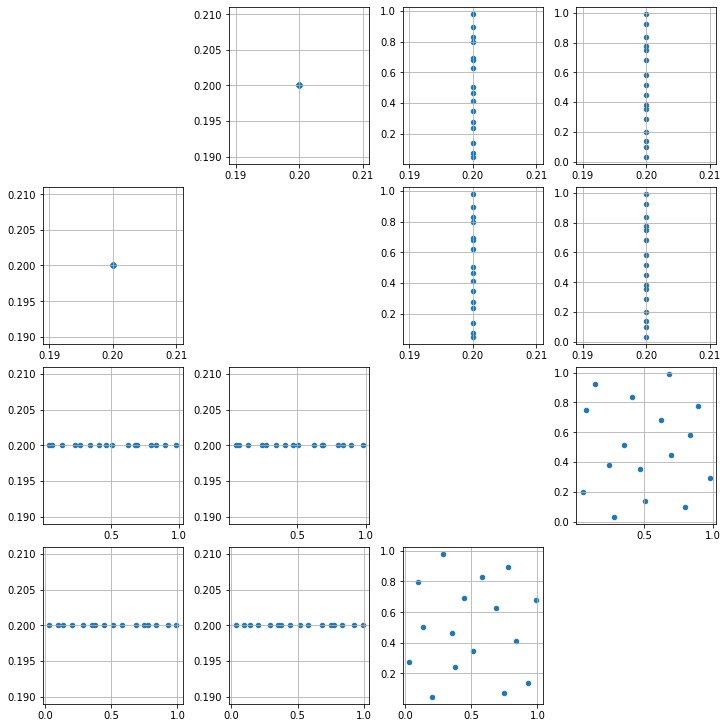

In [343]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10), constrained_layout=True)

for (xi,x_idx) in enumerate([0,1,14,13]):
    for (yi,y_idx) in enumerate([0,1,14,13]):
        ax = axes[xi, yi]
        if xi == yi:
            ax.set_visible(False)
        else:
            ax.scatter(samples[:, x_idx], samples[:, y_idx], s=20)
            ax.grid(True)
plt.show()

In [ ]:
# Expensive bit
def evaluate_samples(samples):
    f = []
    for i in range(len(samples)):
        f.append(model([list(samples[i])]))
        print("Computed sample ", i)
    return np.array(f)
feval = evaluate_samples(samples)

mean_estimate = np.mean(feval, axis=0)
print("Mean estimate:", mean_estimate)

var_estimate = np.var(feval, axis=0)
print("Variance estimate:", var_estimate)

import pickle

with open('out_samples.txt', 'wb+') as f:
    pickle.dump(samples, f)
with open('out_evals.txt', 'wb+') as f:
    pickle.dump(feval, f)

Computed sample  0
Computed sample  1
Computed sample  2
Computed sample  3
Computed sample  4
Computed sample  5
Computed sample  6
Computed sample  7
Computed sample  8
Computed sample  9
Computed sample  10


In [332]:
with open('out_samples.txt', 'rb') as f:
    samples = pickle.load(f)
with open('out_evals.txt', 'rb') as f:
    feval = pickle.load(f)

print("Average runtime ", mean_estimate[0][18], " runtime variance ", var_estimate[0][18])

Average runtime  307.1219037375031  runtime variance  82.16424245805364


In [333]:
# Check if any pressure exceeds 200bar
output_pressure = [feval[i, 0, 1:4] for i in range(len(samples))]
#print(output_pressure)
for (idx,f) in enumerate(output_pressure):
    if np.any([px >= 200 for px in f]):
            print("Sample", samples[idx] , " at pressure ", f, "exceeds 200 bar")

In [334]:
# Check gas in NOGO area
output_gas = [feval[i, 0, 4:-1] for i in range(len(samples))]

s = 0
valid_samples = []
for (it,f) in enumerate(output_gas):
    if np.sum([px for px in f]) > 0.0:
        print("Sample ", it, " has ", sum([px for px in f]) , " gas in NOGO area")
        s = s+1
    else:
        valid_samples.append(output_gas[it])
print("Number of samples with gas ", s)

Sample  0  has  1.8680060600000001  gas in NOGO area
Sample  2  has  0.684901587  gas in NOGO area
Sample  3  has  2.48220129  gas in NOGO area
Sample  4  has  1.571595378  gas in NOGO area
Sample  5  has  0.3103336  gas in NOGO area
Sample  7  has  1.77014174  gas in NOGO area
Sample  8  has  1.30069341  gas in NOGO area
Sample  10  has  0.7255725719999999  gas in NOGO area
Sample  11  has  2.47301195  gas in NOGO area
Sample  12  has  2.1524524825  gas in NOGO area
Sample  13  has  1.05907114  gas in NOGO area
Sample  15  has  2.4437237649999997  gas in NOGO area
Number of samples with gas  12


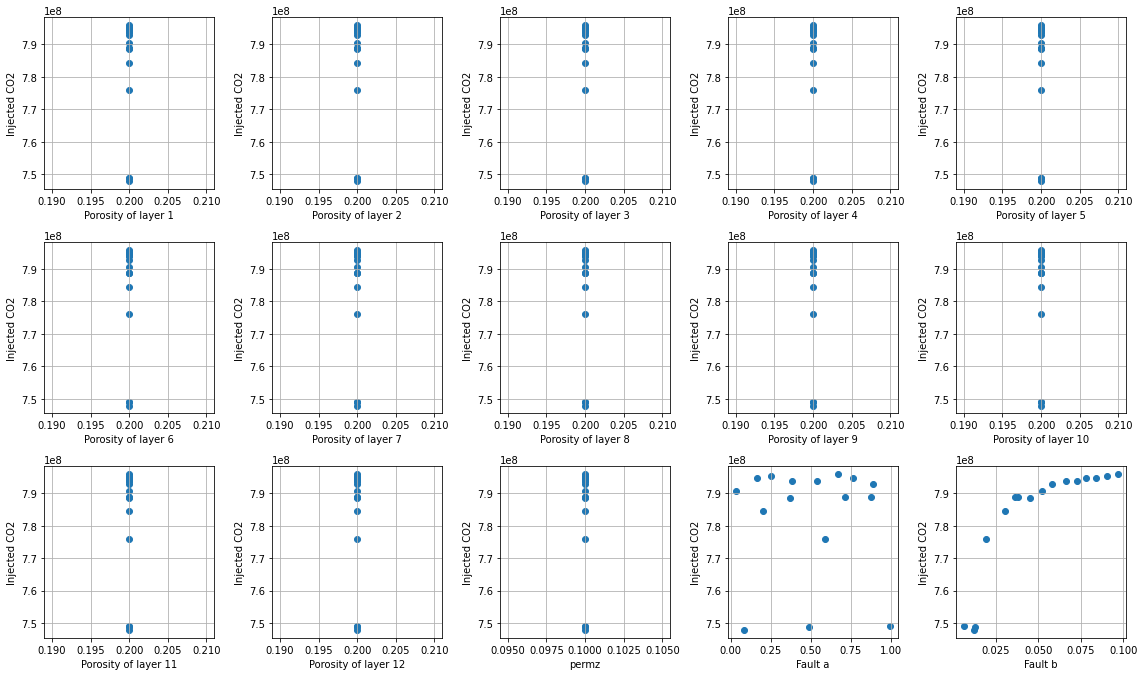

In [335]:
output0 = [feval[i, 0, 0] for i in range(len(samples))]

fig, axs = plt.subplots(3, 5, figsize=(16, 10))
for j in range(n_inputs):
    row, col = divmod(j, 5)
    ax = axs[row, col]
    ax.scatter(samples[:, j], output0)
    if j<12:
        ax.set_xlabel(f'Porosity of layer {j+1}')
    if j == 12:
        ax.set_xlabel(f'permz')
    if j == 13:
        ax.set_xlabel(f'Fault a')
    if j == 14:
        ax.set_xlabel(f'Fault b')
    ax.set_ylabel('Injected CO2')
    ax.grid(True)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

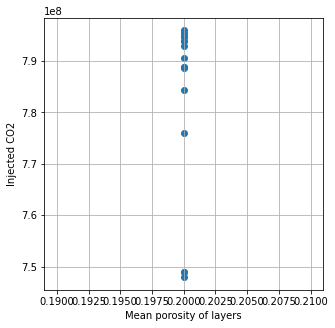

In [337]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(sum([samples[:, j]/12 for j in range(12)]), output0)
ax.set_xlabel(f'Mean porosity of layers')
ax.set_ylabel('Injected CO2')
ax.grid(True)
plt.show()

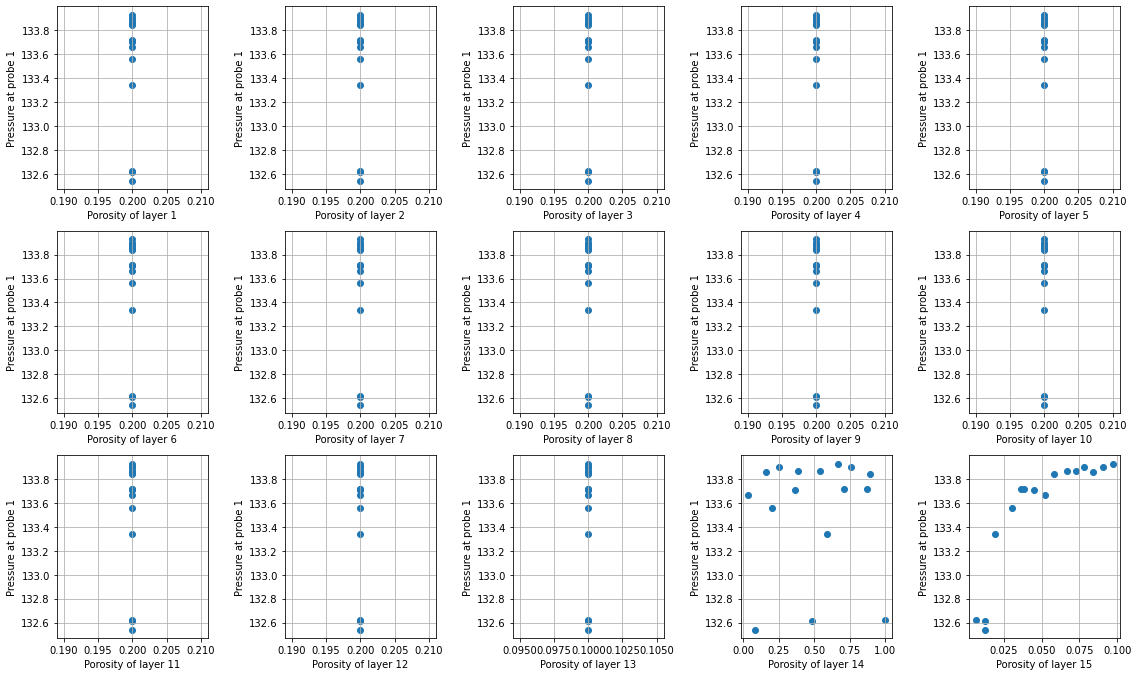

In [338]:
output1 = [feval[i, 0, 1] for i in range(len(samples))]

fig, axs = plt.subplots(3, 5, figsize=(16, 10))
for j in range(n_inputs):
    row, col = divmod(j, 5)
    ax = axs[row, col]
    ax.scatter(samples[:, j], output1)
    ax.set_xlabel(f'Porosity of layer {j+1}')
    ax.set_ylabel('Pressure at probe 1')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

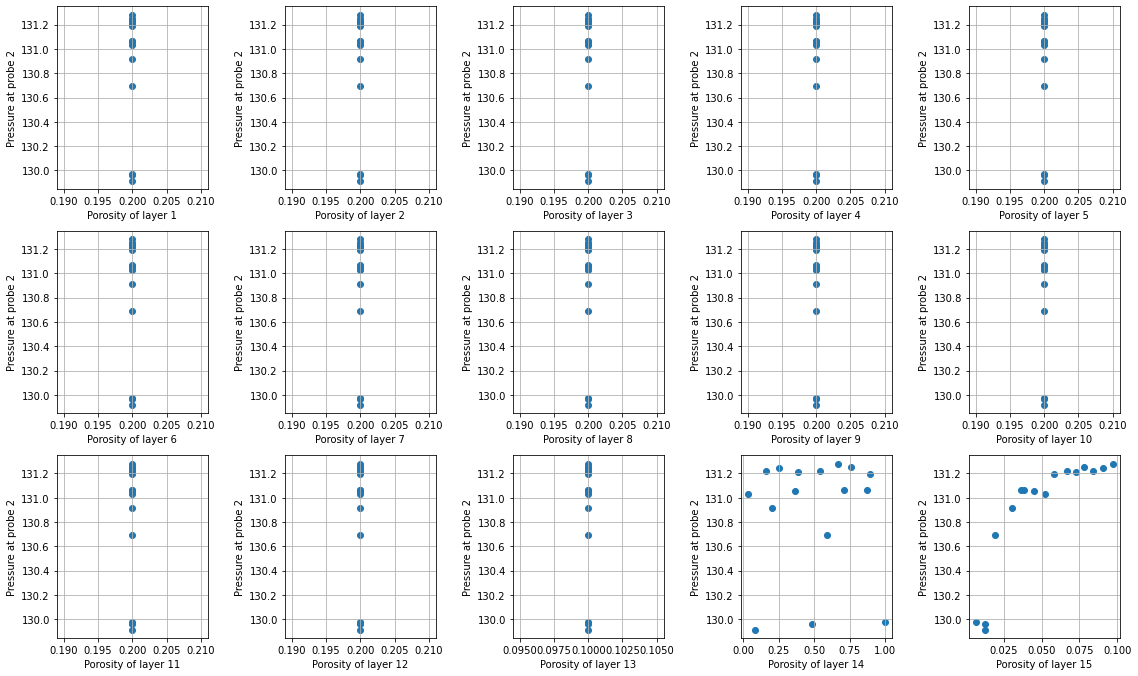

In [339]:
output2 = [feval[i, 0, 2] for i in range(len(samples))]

fig, axs = plt.subplots(3, 5, figsize=(16, 10))
for j in range(n_inputs):
    row, col = divmod(j, 5)
    ax = axs[row, col]
    ax.scatter(samples[:, j], output2)
    ax.set_xlabel(f'Porosity of layer {j+1}')
    ax.set_ylabel('Pressure at probe 2')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

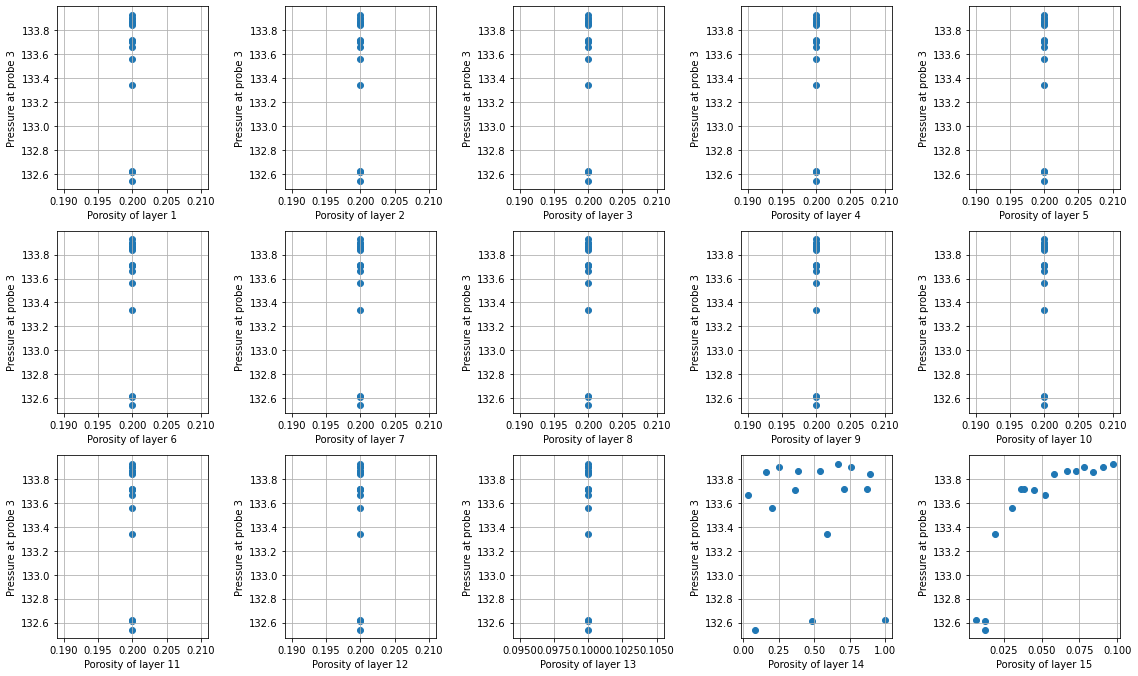

In [340]:
output3 = [feval[i, 0, 3] for i in range(len(samples))]

fig, axs = plt.subplots(3, 5, figsize=(16, 10))
for j in range(n_inputs):
    row, col = divmod(j, 5)
    ax = axs[row, col]
    ax.scatter(samples[:, j], output1)
    ax.set_xlabel(f'Porosity of layer {j+1}')
    ax.set_ylabel('Pressure at probe 3')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

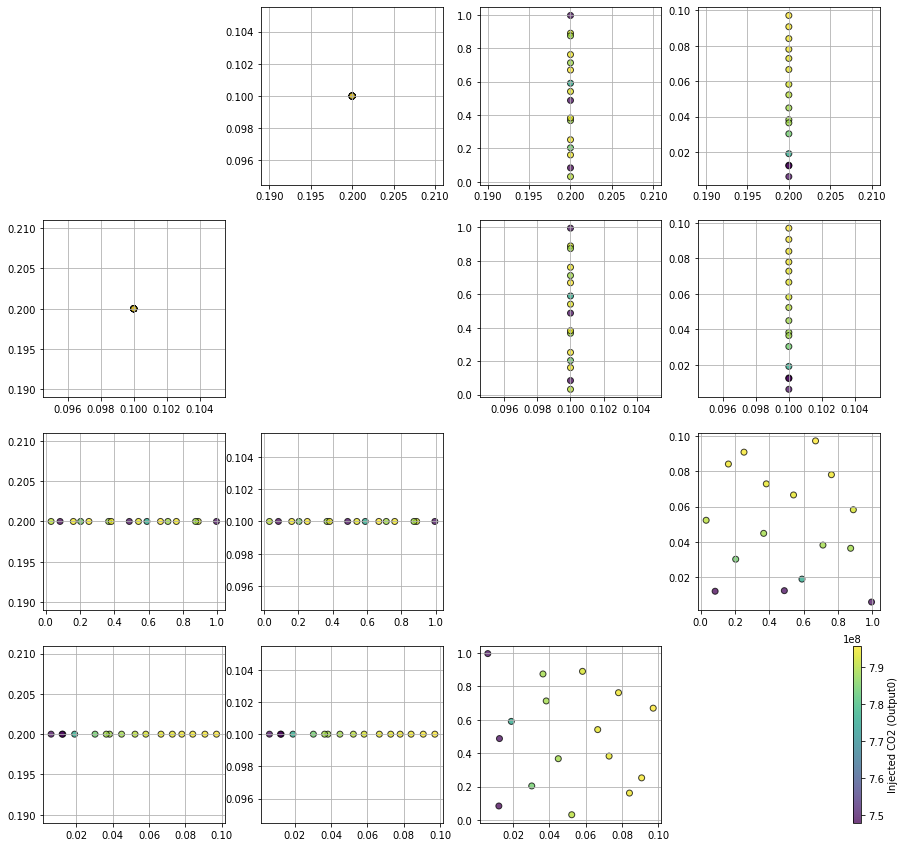

In [341]:
from scipy.interpolate import griddata 

n_plot = 4
fig, axs = plt.subplots(n_plot, n_plot, figsize=(15, 15))

for ih in range(n_plot):
    for jh in range(n_plot):
        ax = axs[ih, jh]
        i = ih + 11
        j = jh + 11
        if i == j:
            ax.set_visible(False)
        else:
            x = samples[:, i]
            y = samples[:, j]
            scatter = ax.scatter(x, y, c=output0, cmap='viridis', edgecolors='k', alpha=0.75)
            ax.grid(True)
        if ih == n_plot - 1 and jh == n_plot - 1:
            fig.colorbar(scatter, ax=ax, label='Injected CO2 (Output0)')
plt.show()

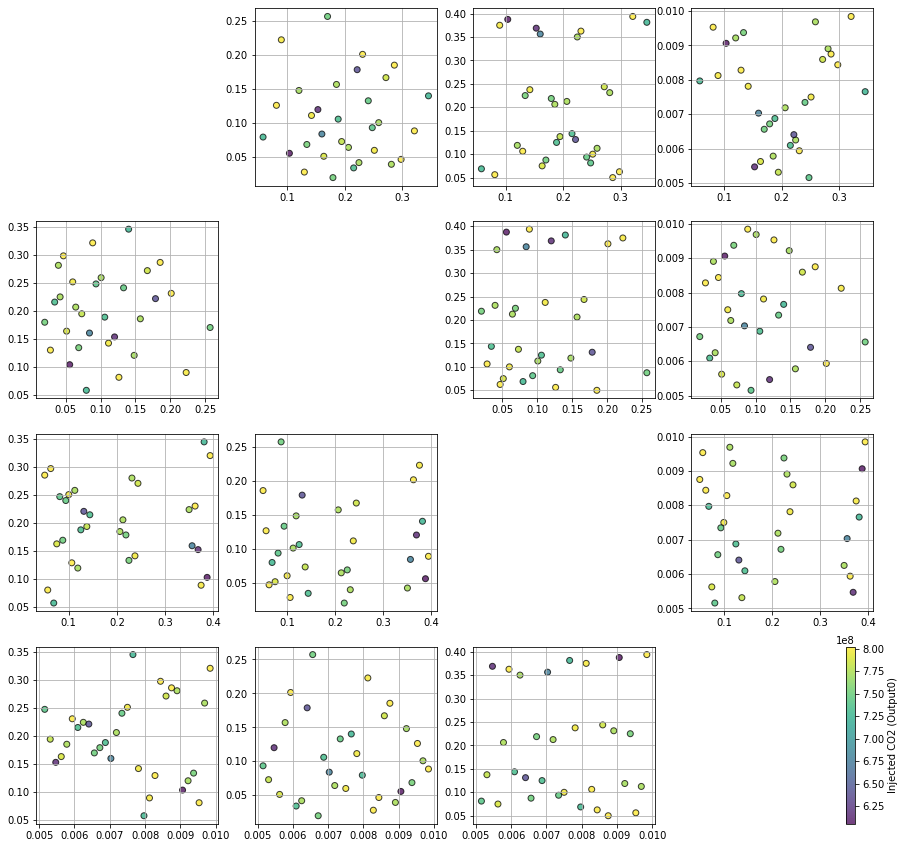

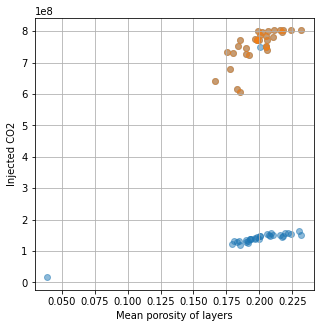

In [187]:
import copy

divide_idx = []
divide_sample = copy.copy(samples)
for (idx,o) in enumerate(output0):
    #print(samples[idx,14])
    if samples[idx,14] > 0.005:
        divide_idx.append(idx)
        
divide_sample = divide_sample[divide_idx]

output0_div = [feval[i, 0, 0] for i in divide_idx]
n_plot = 4
fig, axs = plt.subplots(n_plot, n_plot, figsize=(15, 15))

for ih in range(n_plot):
    for jh in range(n_plot):
        ax = axs[ih, jh]
        i = ih + 11
        j = jh + 11
        if i == j:
            ax.set_visible(False)
        else:
            x = divide_sample[:,i]
            y = divide_sample[:, j]
            scatter = ax.scatter(x, y, c=output0_div, cmap='viridis', edgecolors='k', alpha=0.75)
            ax.grid(True)
        if ih == n_plot - 1 and jh == n_plot - 1:
            fig.colorbar(scatter, ax=ax, label='Injected CO2 (Output0)')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(sum([samples[:, j]/12 for j in range(12)]), output0, alpha = 0.5)
ax.scatter(sum([divide_sample[:,j]/12 for j in range(12)]),output0_div, alpha = 0.5)
ax.set_xlabel(f'Mean porosity of layers')
ax.set_ylabel('Injected CO2')
ax.grid(True)
plt.show()

In [129]:
print(feval)

[[[1.546945e+07 1.854585e+02 1.002533e+02 ... 0.000000e+00 0.000000e+00
   0.000000e+00]]

 [[7.486737e+08 1.686307e+02 1.656009e+02 ... 0.000000e+00 0.000000e+00
   0.000000e+00]]

 [[7.981455e+08 1.694024e+02 1.664452e+02 ... 0.000000e+00 0.000000e+00
   0.000000e+00]]

 ...

 [[7.740585e+08 1.690661e+02 1.662528e+02 ... 0.000000e+00 0.000000e+00
   0.000000e+00]]

 [[8.019454e+08 1.689812e+02 1.659642e+02 ... 0.000000e+00 0.000000e+00
   0.000000e+00]]

 [[1.363592e+08 1.999590e+02 1.972223e+02 ... 0.000000e+00 0.000000e+00
   0.000000e+00]]]


In [239]:
it  = 0
for out in output0:
    if out == max(output0):
        print("Max ", out)
        print("index", it)
        print("Parameters", samples[it])
    if out == min(output0):
        print("Min ", out)
        print("index", it)
        print("Parameters", samples[it])
        
    it += 1

Min  30719600.0
index 0
Parameters [0.20029381 0.20029381 0.20029381 0.20029381 0.20029381 0.20029381
 0.20029381 0.20029381 0.20029381 0.20029381 0.20029381 0.20029381
 0.09590741 0.5        0.1       ]
Max  804871800.0
index 6
Parameters [0.11499228 0.22447775 0.17613802 0.11499228 0.11499228 0.17613802
 0.22447775 0.22447775 0.22447775 0.2860637  0.22447775 0.11499228
 0.11715876 0.5        0.1       ]


#### Next steps

- could do sobol indices, but need qmcpy for that, but would also add adaptive sampling which might be good


For extending to multilevel setting we need some implementation of MLQMC. Maybe good to start from:
https://bitbucket.org/pefarrell/pymlmc/src/master/

In [226]:
store_samples = samples